### **Imports and setup** 
Import packages, the config.py and architecture.py files and set global parameters

In [1]:
from config import (
    LEARNING_RATE,
    NUM_EPOCHS,
    TRAIN_SIZE,
    FP_BITS,
    FP_RADIUS,
    node_feat_list,
    edge_feat_list,
    BATCH_SIZE,
    NUM_ESTIMATORS,
)
from pkasolver.constants import SEED, DEVICE, node_feat_values, edge_feat_values
from pkasolver.data import (
    load_data,
    preprocess_all,
    train_validation_set_split,
    make_stat_variables,
    make_pyg_dataset_from_dataframe,
    calculate_nr_of_features,
    
)
from pkasolver.ml_architecture import (
    gcn_full_training,
    gcn_full_training_val_optimisation,
    GCNPairSingleConv,
    GCNPairTwoConv,
    GCNProt,
    GCNDeprot,
    NNConvPair,
    NNConvDeprot,
    NNConvProt,
    GATPair, 
    GATProt, 
    GINPairV1,
    GINPairV2, 
    GINProt

)
from pkasolver.chem import generate_morgan_fp_array, calculate_tanimoto_coefficient
from pkasolver.ml import dataset_to_dataloader, test_ml_model, test_graph_model
from pkasolver.stat import compute_stats, compute_kl_divergence, calc_rmse
import random
import os
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

plt.rcParams["figure.figsize"] = (6.25, 6.25)
# plt.rcParams["figure.figsize"] = (12.5, 12.5)
sns.set_theme(style="ticks")

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display

import torch
from torch import optim
from rdkit.Chem import Draw, Mol
random.seed(SEED)
imgdir = "images_and_tables"
os.makedirs(imgdir, exist_ok=True)

num_node_features = calculate_nr_of_features(node_feat_list)
num_edge_features = calculate_nr_of_features(edge_feat_list)

Setting num threads to 1
Pytorch will use cuda


In [2]:
def plot_results(results, title):
    plt.plot(results['training-set'], label='training set')
    plt.plot(results['validation-set'], label='validation set')
    if title:
        plt.title(title)
    plt.ylim([0,4])
    plt.legend()
    plt.show()

## **Data Preprocessing**

#### **Import raw data**
Load data from sdf files, create conjugate molescules and store them in pandas DataFrames

Loading data ...
dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,smiles,protonated,deprotonated
536,9.7,9.63,4,basic,['chembl25'],871123,CC(C)(C)[NH2+]CC(O)c1cc(Cl)c(N)c(C(F)(F)F)c1,,

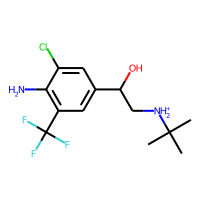
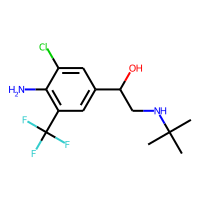

In [3]:
# make sure the directory for saving the run data exists 
# run_data stores pickle files of the dicts containing dataset-Dataframes, morgan fingerprints and pyG graphs)
run_filename = "run_data"
os.makedirs(f"{run_filename}/", exist_ok=True)

# check if saved dictonary of dataset-Dataframes is available and if so, import it
if os.path.isfile(f"{run_filename}/dataset_dfs.pkl"):
    print("Loading data ...")
    with open(f"{run_filename}/dataset_dfs.pkl", "rb") as pickle_file:
        dataset_dfs = pickle.load(pickle_file)

# create DataFrames for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    print("Generating data ...")
    sdf_paths = load_data("../../data/Baltruschat/")
    dataset_dfs = preprocess_all(sdf_paths) # load all datasets in Dataframes and calculate protonated and deprotonated conjugates
    dataset_dfs["train_split"], dataset_dfs["val_split"] = train_validation_set_split(
        dataset_dfs["Training"], TRAIN_SIZE, SEED
    ) # take a copy of the "Training" dataset, shuffle and split it into train and validation datasets and store them as Dataframe in respective dict   

    with open(f"{run_filename}/dataset_dfs.pkl", "wb") as pickle_file:
        pickle.dump(dataset_dfs, pickle_file)

# notification
print(dataset_dfs.keys())
display(dataset_dfs["train_split"].head(1))

# **Calulate fingerprint based data**
Create Fingerprints, target-value objects and add best tanimoto similarities of fps form external validation set molecules with those of the train molecules

In [4]:
# check if saved dictonary of fingerprint data is available and if so, import it
if os.path.isfile(f"{run_filename}/fp_data.pkl"):
    with open(f"{run_filename}/fp_data.pkl", "rb") as pickle_file:
        fp_data = pickle.load(pickle_file)

# create fingerprint arrays (dim: num molecules x fp bits) for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    fp_data = {}
    for name, df in dataset_dfs.items():
        X_feat, y = make_stat_variables(df, [], ["pKa"])
        X_prot = generate_morgan_fp_array(
            df, "protonated", nBits=FP_BITS, radius=FP_RADIUS, useFeatures=True
        )
        X_deprot = generate_morgan_fp_array(
            df, "deprotonated", nBits=FP_BITS, radius=FP_RADIUS, useFeatures=True
        )
        X = np.concatenate((X_prot, X_deprot), axis=1)
        fp_data[f"{name}"] = {"prot": X_prot, "deprot": X_deprot, "pair": X, "y": y}

    with open(f"{run_filename}/fp_data.pkl", "wb") as f:
        pickle.dump(fp_data, f)

# add max tanimotosimilarity to the Dataframes of external test sets
    train_name = "train_split"
    val_name = "val_split"
    training = "Training"
    for name, dataset in fp_data.items():
        if name in [train_name, val_name, training]:
            pass
        else:
            print(f"calculating similarities for {name}")
            max_scores = []
            for test_mol in dataset["prot"]:
                scores = []
                for ref_mol in fp_data[train_name]["prot"]:
                    scores.append(calculate_tanimoto_coefficient(test_mol, ref_mol))
                max_scores.append(max(scores))
            dataset_dfs[name]["Similarity_max"] = max_scores

with open(f"{run_filename}/dataset_dfs.pkl", "wb") as f:
    pickle.dump(dataset_dfs, f)

# notification
print("fp_data keys:", fp_data.keys())
print(f"calculated/loaded fingerprint data successfully")

fp_data keys: dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])
calculated/loaded fingerprint data successfully


# **Calculate graph data**
Create graph data with node and edge features specified in the config file and prepare loaders

In [5]:
# check if saved dictonary of graph data is available and if so, import it
if os.path.isfile(f"{run_filename}/graph_data.pkl"):
    print("Loading data ...")
    with open(f"{run_filename}/graph_data.pkl", "rb") as f:
        graph_data = pickle.load(f)

# create list of 'PairData' graph objects for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    print("Generating data ...")
    graph_data = {}
    for name, df in dataset_dfs.items():
        print(f"Generating data for: {name}")
        graph_data[name] = make_pyg_dataset_from_dataframe(
            df, node_feat_list, edge_feat_list, paired=True
        )
    with open(f"{run_filename}/graph_data.pkl", "wb") as f:
        pickle.dump(graph_data, f)

print("graph_data keys:", graph_data.keys())

# create an iterable loader object from the list of graph data of each dataset and store them in a dictonary
loaders = {}
for name, dataset in graph_data.items():
    print(f"Generating loader for {name}")
    if name == "Training":
        print("Skipping unsplit Training dataset")
        continue
    elif name == "train_split" or name == "val_split":
        loaders[name] = dataset_to_dataloader(dataset, BATCH_SIZE, shuffle=True) # Shuffling is essential to avoid overfitting on particular batches
    else:
        loaders[name] = dataset_to_dataloader(dataset, BATCH_SIZE, shuffle=False) # Testsets must not be shuffled in order to be able to calculate per datapoint predcitons with all graph and baselinemodels in the analysis part

# notification
print("loaders keys:", loaders.keys())
print(f"calculated/loaded graph data successfully")

Loading data ...
graph_data keys: dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])
Generating loader for Training
Skipping unsplit Training dataset
Generating loader for Novartis
Generating loader for Literature
Generating loader for train_split
Generating loader for val_split
loaders keys: dict_keys(['Novartis', 'Literature', 'train_split', 'val_split'])
calculated/loaded graph data successfully


In [6]:
from config import node_feat_values
pd.set_option('display.max_columns', None)
def color_positive_red(val):
    color = 'red' if val > 0 else 'black'
    return 'color: %s' % color

lst = graph_data['Novartis'][1].x_p


node_feat_names = []
for feat in node_feat_list:
    values = node_feat_values[feat]
    for value in values:
        node_feat_names.append(f'{feat} = {value}')

df = pd.DataFrame(lst, columns= node_feat_names, dtype=int)
df.style.applymap(color_positive_red)

,element = 1,element = 6,element = 7,element = 8,element = 9,element = 15,element = 16,element = 17,element = 33,element = 35,element = 53,formal_charge = -1,formal_charge = 0,formal_charge = 1,hybridization = 1,hybridization = 2,hybridization = 3,hybridization = 4,total_num_Hs = 0,total_num_Hs = 1,total_num_Hs = 2,total_num_Hs = 3,aromatic_tag = 1,total_valence = 1,total_valence = 2,total_valence = 3,total_valence = 4,total_valence = 5,total_valence = 6,total_degree = 1,total_degree = 2,total_degree = 3,total_degree = 4,is_in_ring = 1,reaction_center = 1,smarts = -OSO3H,smarts = –SO3H,smarts = -OSO2H,smarts = -SO2H,smarts = -OPO3H2,smarts = -PO3H2,smarts = -CO2H,smarts = thiophenol,smarts = (-OPO3H)-,smarts = (-PO3H)-,smarts = phthalimide,smarts = CO3H (peracetyl),smarts = alpha-carbon-hydrogen-nitro group,smarts = -SO2NH2,smarts = -OBO2H2,smarts = -BO2H2,smarts = phenol,smarts = SH (aliphatic),smarts = (-OBO2H)-,smarts = (-BO2H)-,smarts = cyclopentadiene,smarts = -CONH2,smarts = imidazole,smarts = -OH (aliphatic alcohol),smarts = alpha-carbon-hydrogen-keto group,smarts = alpha-carbon-hydrogen-acetyl ester group,smarts = sp carbon hydrogen,smarts = alpha-carbon-hydrogen-sulfone group,smarts = alpha-carbon-hydrogen-sulfoxide group,smarts = -NH2,smarts = benzyl hydrogen,smarts = sp2-carbon hydrogen,smarts = sp3-carbon hydrogen,smarts = Hydrogen-bond acceptor,smarts = Hydrogen-bond donor,smarts = Possible intramolecular H-bond
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [7]:
graph_data['Novartis'][1].x_p


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

**show feature value range**

In [8]:
# # print all possible node feature values
# values = [set() for i in range(len(node_feat_list))]
# for dataset in graph_data.values():
#     for entry in dataset:
#         for i, row in enumerate(entry.x_p.cpu().T):
#             values[i] = values[i] | set(row.numpy())
#         for i, row in enumerate(entry.x_d.cpu().T):
#             values[i] = values[i] | set(row.numpy())
# print("Node features:")
# for name, values in zip(node_feat_list, values):
#     x = list(values)
#     x.sort()
#     print(f"{name}:{x}")
# print("\n")

# # print all possible edge feature values
# values = [set() for i in range(len(edge_feat_list))]
# for dataset in graph_data.values():
#     for entry in dataset:
#         for i, row in enumerate(entry.edge_attr_p.cpu().T):
#             values[i] = values[i] | set(row.numpy())
#         for i, row in enumerate(entry.edge_attr_d.cpu().T):
#             values[i] = values[i] | set(row.numpy())
# print("Edge features:")
# for name, values in zip(edge_feat_list, values):
#     x = list(values)
#     x.sort()
#     print(f"{name}:{x}")



# **Training of predictive models**

## **train baseline models**
train all baseline models in protonated, deprotonated and pair mode

In [9]:
# models_dict = {
#     "RFR": RandomForestRegressor(
#         n_estimators=NUM_ESTIMATORS, random_state=SEED
#     ),  # Baltruschat n_estimatores = 1000
#     "PLS": PLSRegression(),
# }

# baseline_models = {}
# train_name = "train_split"
# val_name = "val_split"

# for model_name, model_template in models_dict.items():
#     baseline_models[model_name] = {}
#     for mode, X in fp_data[train_name].items():
#         if mode == "y":
#             continue
#         path = f"models/baseline/{model_name}/{mode}/"
#         if os.path.isfile(path + "model.pkl"):
#             with open(path + "model.pkl", "rb") as pickle_file:
#                 baseline_models[model_name][mode] = pickle.load(pickle_file)
#         else:
#             print(f"Training {model_name}_{mode}...")
#             y = fp_data[train_name]["y"]
#             y_val = fp_data[val_name]["y"]
#             model = copy.deepcopy(model_template)
#             model.fit(X, y)
#             print(f"{model_name}_{mode}: {model.score(fp_data[val_name][mode], y_val)}")
#             baseline_models[model_name][mode] = model
#             os.makedirs(path, exist_ok=True)
#             with open(path + "model.pkl", "wb") as pickle_file:
#                 pickle.dump(model, pickle_file)
# print(f"trained/loaded baseline models successfully")

# **Train graph models**

## **Training**
train all graph models in protonated, deprotonated and pair mode

Attention: RELOADING model
Attention: RELOADING model
1961
Number of parameters:  16129
Training GCNPairTwoConv at epoch 1961 ...
LR: 0.001
GCNPairTwoConv
GCNPairTwoConv(
  (pool): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=71, out_features=71, bias=True)
    (1): ReLU()
    (2): Linear(in_features=71, out_features=1, bias=True)
  ), nn=None)
  (convs_p): ModuleList(
    (0): GCNConv(71, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 32)
  )
  (convs_d): ModuleList(
    (0): GCNConv(71, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 32)
  )
  (lins): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)
Training on cuda.


Train MAE: 0.3160, Validation MAE: 0.6330: 100%|██████████| 40/40 [01:45<00:00,  2.64s/it]


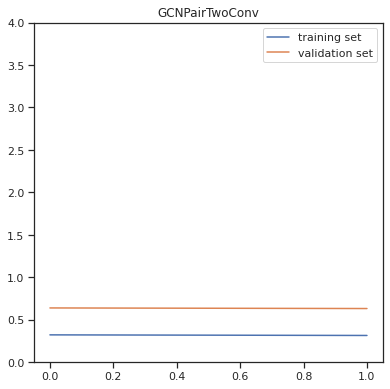

Attention pooling: False
0
Number of parameters:  10689
Training GCNProt at epoch 0 ...
LR: 0.001
GCNProt
GCNProt(
  (pool): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=71, out_features=71, bias=True)
    (1): ReLU()
    (2): Linear(in_features=71, out_features=1, bias=True)
  ), nn=None)
  (convs): ModuleList(
    (0): GCNConv(71, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 32)
  )
  (lins): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)
Training on cuda.


Train MAE: 0.3980, Validation MAE: 0.6730: 100%|██████████| 2001/2001 [30:46<00:00,  1.08it/s]


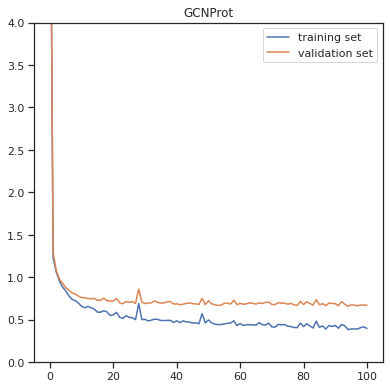

Attention pooling: False
0
Number of parameters:  10689
Training GCNDeprot at epoch 0 ...
LR: 0.001
GCNDeprot
GCNDeprot(
  (pool): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=71, out_features=71, bias=True)
    (1): ReLU()
    (2): Linear(in_features=71, out_features=1, bias=True)
  ), nn=None)
  (convs): ModuleList(
    (0): GCNConv(71, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 32)
  )
  (lins): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)
Training on cuda.


Train MAE: 0.3880, Validation MAE: 0.6290: 100%|██████████| 2001/2001 [25:41<00:00,  1.30it/s]


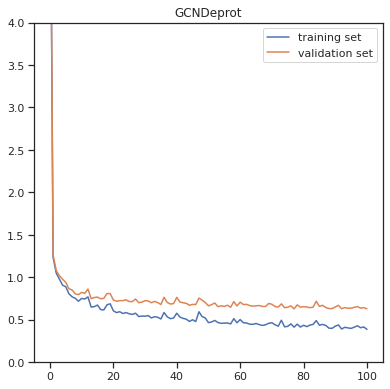

Attention pooling: False
0
Number of parameters:  56897
Training NNConvPair at epoch 0 ...
LR: 0.001
NNConvPair
NNConvPair(
  (pool): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=71, out_features=71, bias=True)
    (1): ReLU()
    (2): Linear(in_features=71, out_features=1, bias=True)
  ), nn=None)
  (convs_d): ModuleList(
    (0): NNConv(71, 16, aggr="add", nn=Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=1136, bias=True)
    ))
    (1): NNConv(16, 16, aggr="add", nn=Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=256, bias=True)
    ))
    (2): NNConv(16, 16, aggr="add", nn=Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=256, bias=True)
    ))
  )
  (convs_p): ModuleList(
    (0): NNConv(71, 16, ag

Train MAE: 1.3040, Validation MAE: 1.4690:  27%|██▋       | 536/2001 [10:50<27:47,  1.14s/it]

In [10]:
from pkasolver.ml_architecture import GINProt, GINPairV1,GINPairV2, AttentiveProt
NUM_EPOCHS = 2000

models = [('GCNPairSingleConv', GCNPairSingleConv), 
('GCNPairTwoConv', GCNPairTwoConv), 
('GCNProt', GCNProt), 
('GCNDeprot', GCNDeprot), 
('NNConvPair', NNConvPair), 
('NNConvDeprot', NNConvDeprot), 
('NNConvProt', NNConvProt )]

# models = [("AttentiveProt", AttentiveProt), ("GINPairV2", GINPairV2), ("GINPairV1", GINPairV1), ]


for model_name, model_class in models:
    path = f"models/gcn/"
    os.makedirs(path, exist_ok=True)
    pkl_file_name = f"{path}/{model_name}.pkl"
    if os.path.isfile(pkl_file_name):
        print('Attention: RELOADING model')
        with open(pkl_file_name, "rb") as pickle_file:
            model = pickle.load(pickle_file)
    else:
        model = model_class(num_node_features, num_edge_features, hidden_channels = 32)

    if model.checkpoint["epoch"] < NUM_EPOCHS:
        model.to(device=DEVICE)
        print(model.checkpoint["epoch"])
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        print("Number of parameters: ", sum(p.numel() for p in model.parameters()))            
        try:
            optimizer.load_state_dict(model.checkpoint["optimizer_state"])
        except:
            pass
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=5, verbose=True
        )

        print(
            f'Training {model_name} at epoch {model.checkpoint["epoch"]} ...'
        )
        print(f'LR: {LEARNING_RATE}')
        print(model_name)
        print(model)
        print(f'Training on {DEVICE}.')
        # results = gcn_full_training_val_optimisation(
        results = gcn_full_training(
            model.to(device=DEVICE),
            loaders["train_split"],
            loaders["val_split"],
            optimizer,
            pkl_file_name,
            NUM_EPOCHS,
        )

        plot_results(results, f'{model_name}')
        with open(f"{path}/{model_name}.pkl", "wb") as pickle_file:
            pickle.dump(model.to(device='cpu'), pickle_file)
print(f"trained/loaded gcn models successfully")

In [ ]:
graph_models = {}
for model_name, model_class in models:
    path = f"models/gcn/"
    os.makedirs(path, exist_ok=True)
    pkl_file_name = f"{path}/{model_name}.pkl"
    if os.path.isfile(pkl_file_name):
        with open(pkl_file_name, 'rb') as pickle_file:
            model = pickle.load(pickle_file)
        model.to(device='cpu')
        best_loss = max([x for x in model.checkpoint['best_states'].keys() if x < 4_000]) 
        model.load_state_dict(model.checkpoint['best_states'][best_loss][1])
        loss = model.checkpoint['best_states'][best_loss][0]
        print(f'{model_name},Epoch {best_loss}, Loss:{loss}')
        graph_models[model_name] = model
    else:
        print(f'{path} not found')

In [ ]:
#Predictions of baseline and graph models

for i,test_set in enumerate(['Novartis', 'Literature', 'val_split']):

    df_gcn = test_graph_model(graph_models, loaders[test_set],test_set)
    try:
        df_ml = test_ml_model(baseline_models, fp_data[test_set], fp_data[test_set]['y'],test_set)
        df= pd.concat([df_ml.drop(columns=['Dataset', 'pKa_true']),df_gcn],axis=1)
    except:
        df= pd.concat([df_gcn],axis=1)
    torch.cuda.empty_cache()
    if i == 0:
        df_res = df
    else:
        df_res = pd.concat([df_res,df])
display(df_res)

In [ ]:
test= compute_stats(df_res, 'Dataset', 'pKa_true')
test.to_csv(f'{imgdir}/stat_metrics.csv')
display(test)

Plot best model
Plot the predictions of the best models for the validation and the two testsets

In [ ]:
def plot_results(df, x_col, y_col, hue_col = "Dataset"):
    df = df.reset_index()
    # Define plot canvas
    g = sns.jointplot(data=df, x=x_col, y=y_col, hue=hue_col, xlim=(2,12), ylim=(2,12))

    # Add fit_reg lines to plot 
    for _,gr in df.groupby(hue_col):
        sns.regplot(x=x_col, y=y_col, data=gr, scatter=False, ax=g.ax_joint, truncate=False)

    # Add Diagonal line to Joint axes
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = np.array([max(x0, y0), min(x1, y1)])
    g.ax_joint.plot(lims, lims, '-r')
    # Add error band of pka ± 1
    g.ax_joint.fill_between(lims, lims - 1, lims + 1, color="r", alpha=0.2)

    return g

def calc_stat_info(y, y_hat, name):

    stat_info = f"""
        {name}
        $r^2$ = {r2_score(y, y_hat): .2f}
        $MAE$ = {mean_absolute_error(y, y_hat): .2f}
        $RMSE$ = {calc_rmse(y, y_hat): .2f}
        $kl_div$ = {compute_kl_divergence(y_hat,y): .2f}
        """
    
    return stat_info

def stat_info_dict(df,x_col, y_col,datasets:list):
    info_dict = {}
    for name in datasets:
        data = df[df["Dataset"]==name]
        y, y_hat = data[x_col], data[y_col]
        info_dict[name] = calc_stat_info(y,y_hat, name)
    return info_dict

In [ ]:
sns.set_context('paper')
set_list = ["Novartis", "Literature"]
d = df_res[df_res["Dataset"].isin(set_list)] 
# model='GCN_prot_edge'
for model in d.columns.drop(["pKa_true", "Dataset"]):
    # g = plot_results(d[d['Dataset']== dataset], 'pKa_true', model)
    g = plot_results(d, 'pKa_true', model)
    g.set_axis_labels('exp', 'pred')
    g.fig.suptitle(f' {model}')
    stat_info = stat_info_dict(d,'pKa_true', model, set_list)
    g.ax_joint.text(0.25, 1, stat_info['Novartis'], size='x-small', ha='left', va="top", transform = g.ax_joint.transAxes)
    # Add stats Literature
    g.ax_joint.text(1, 0, stat_info['Literature'], size='x-small', ha='right', va="bottom", transform = g.ax_joint.transAxes)
    plt.savefig(f'{imgdir}/regression_{model}.pdf', bbox_inches='tight')


GCN training progress

store training losses in DataFrame and

In [ ]:
for m in list(["GCNPairSingleConv","GCNPairTwoConv"]):
    df_prog=pd.DataFrame(graph_models[m].checkpoint['progress_table'])
#     df_prog=pd.DataFrame(graph_models_cv[x][y][1].checkpoint['progress_table'])
    #plot learning
    fig, ax = plt.subplots()
    fig.set_size_inches(3.125,3.125)
    sns.lineplot(x='epoch',y='train_loss', label='Train Loss',data=df_prog,ax=ax)
    sns.lineplot(x='epoch',y='validation_loss',label='Validation Loss',data=df_prog,ax=ax)
    ax.set_ylabel("Loss (MAE)")
    ax.set_xlabel("Epoch")
    ax.set_xlim(left=0, right=2000)
    ax.set_ylim(top=1.75, bottom=0)
#     plt.title(f'training progress of gcn_{x}_{y} model')
    plt.savefig(f'{imgdir}/training_progress_gcn_{m}.pdf',bbox_inches='tight')
    plt.show()

Metrics by tanimoto similarity

In [ ]:
# create dict with df of each test set with a similartiy column added
def create_sim_results(df_in, datasets, sim_df=dataset_dfs, smaller_than=True, step_size=0.1):
    results_dict = {}
    for dataset in datasets:
        df = df_in[df_in['Dataset']==dataset].copy()
        df['similarity'] = sim_df[dataset].loc[:,'Similarity_max']
        df.sort_values(by=['similarity'], inplace=True)

        d = df
        temp_dict = defaultdict(list)
        temp_dict['similarity'] = d["similarity"].unique()
        for x in d["similarity"].unique():
            if smaller_than:
                _d = d[d["similarity"] <= x]
            else:
                _d = d[d["similarity"] >= x]
            for model in _d.columns.drop(["pKa_true", "Dataset", "similarity"]):
                temp_dict[model].append(calc_rmse(_d['pKa_true'], _d[model]))
        temp_df = pd.DataFrame(temp_dict)
        temp_df["Dataset"] = dataset
        sims=[]
        if smaller_than:
            for sim in temp_df['similarity']:
                x=1
                while sim < x:
                    x+= -step_size
                if sim == 1:
                    sims.append(f'= {round(np.clip(x+step_size,0,1),3)}')
                else:
                    sims.append(f'< {round(np.clip(x+step_size,0,1),3)}')
        else:
            for sim in temp_df['similarity']:
                x=0
                while sim > x:
                    x+= step_size
                if sim == 1:
                    sims.append(f'= {round(np.clip(x+step_size,0,1),3)}')
                else:
                    sims.append(f'> {round(np.clip(x+step_size,0,1),3)}')
        temp_df['group']=sims  
        results_dict[dataset] = temp_df
    return results_dict

In [ ]:
results_dict = create_sim_results(df_res, ['Novartis', 'Literature'], sim_df=dataset_dfs, smaller_than=True, step_size=0.1)
a = pd.concat([results_dict["Novartis"], results_dict["Literature"]], axis=0)
for model in df_res.columns.drop(["pKa_true", "Dataset"]):
    sns.scatterplot(data=a, x="similarity", y=model, hue="Dataset")
    plt.xlabel('Similarity')
    plt.ylabel('RMSE')
    plt.title(model)
    plt.savefig(f'{imgdir}/RMSE_sim_{model}.pdf')
    plt.show()
    plt.close()

In [ ]:
for model in df_res.columns.drop(["pKa_true", "Dataset"]):
    ax = sns.catplot(x="group", y="GCNPairSingleConv", hue="Dataset", kind="point", data=a)
    plt.xlabel('Similarity')
    plt.ylabel('RMSE')
    plt.title(model)
    plt.savefig(f'{imgdir}/RMSE_sim_intervals_{model}.pdf')
    plt.show()
    plt.close()


Outliers top list

In [ ]:
def get_2d_molecule(m):
  copy = Mol(m)
  copy.Compute2DCoords(clearConfs=True)
  return copy

def group_by_range(series, range_list, decimal=1):
    group_labels=[]
    for x in series:
        i=0
        while x > range_list[i]:
            i+=1
        group_labels.append(round(range_list[i],decimal))
    return group_labels 

data_set=['Novartis', 'Literature']
best=[True, False]
for data_set in data_set:
    trues= df_res[df_res.Dataset==data_set].pKa_true
    preds= df_res[df_res.Dataset==data_set].GCNPairTwoConv
    diffs = []
    errors = []
    for pred, true in zip(preds,trues):
        diffs.append(pred-true)
        errors.append(abs(pred-true))
    res = pd.concat((pd.DataFrame({'differences':diffs}),pd.DataFrame({'errors':errors}), dataset_dfs['Novartis'].loc[:,('pKa','marvin_atom','protonated', 'deprotonated', 'ID','Similarity_max')]),axis=1)
    
    res_e=res.loc[:, ('errors','pKa','Similarity_max')]
    res_e['pKa']=group_by_range(res_e['pKa'],list(range(2,14,2)))
    res_e['Similarity']=group_by_range(res['Similarity_max'],np.arange(0.0,1.2,0.2))
    res_e=res_e.loc[:, ('errors','pKa','Similarity')]
    res_e=res_e.groupby(['Similarity','pKa']).mean().unstack()
#     display(res_e)
    
    # plt.figure(figsize=(3.125,2.5))
    # sns.heatmap(res_e['errors'], cmap='RdYlGn_r', vmin=0,vmax=1.50)
    # plt.savefig(f'{imgdir}/error_heatmap_{data_set}.pdf', bbox_inches='tight')
    # plt.show()
    
    for mod in best:    
        res.sort_values(by=['errors'], inplace=True, ascending=mod)
        num=6
        img=Draw.MolsToGridImage(res.protonated[:num].map(get_2d_molecule),
                                 molsPerRow=3,
                                 subImgSize=(400,350),
                                 useSVG=True,
                                 highlightAtomLists=[[int(i)] for i in res.marvin_atom[:num]],
                                 legends=[f"error:  {round(x[1],2)}, pKa:  {x[0]}, sim: {x[2]:.3f}" for x in zip(res.pKa[:num],res.differences[:num], res.Similarity_max[:num])])

        display(img)
        name_dict={True:'best',False:'outlier'}
        with open(f'{imgdir}/grid_{data_set}_{name_dict[mod]}.svg', 'w') as f:
            f.write(img.data)
    # res.head()